## Artificial Intelligence for Cybersecurity Project
### Dataset used: [Malicious URLs dataset by Manu Siddhartha](https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset)

### Candidates: Riccardo Fantasia & Leonardo Pantani

In [1]:
# removing warnings from prints
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing raw dataset
import pandas as pd
df_raw = pd.read_csv("UNIPI-IA-dataset.csv")

In [3]:
# we define the types in a specific order. This is because in case of duplicates, for example:
# https://www.strange-site.com/youwonaprize- malware
# https://www.strange-site.com/youwonaprize - benign
#
# we would remove all samples, except the first one. This was decided because, in this context,
# it is preferable to have a False Positive (FP), manually "correctable" by the user, than a False Negative (FN),
# which could expose the user to a malicious site.

types = ["malware", "phishing", "defacement", "benign"]

df_raw["type"] = pd.Categorical(df_raw["type"], categories=types, ordered=True)
df = df_raw.sort_values(by="type").drop_duplicates(subset="url", keep="first")

print(f"Samples in original dataset: {df_raw.shape[0]}\nSamples in no-duplicates dataset: {df.shape[0]} ({((df_raw.shape[0] - df.shape[0]) / df_raw.shape[0]) * 100:.2f}% reduction)")


Samples in original dataset: 651191
Samples in no-duplicates dataset: 641119 (1.55% reduction)


In [4]:
# show for each class the number of urls in the dataset
from plotly import graph_objects as go

total_count = df['type'].shape[0]
count = df['type'].value_counts()
percentages = (count / total_count * 100).round(2)
colors = ['#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6', '#E6B333', '#3366E6', '#999966', '#99FF99', '#B34D4D']

fig = go.Figure(data=[go.Bar(x=count.index, y=count, marker=dict(color=colors), text=[f"{p}%" for p in percentages], textposition='outside', textfont=dict(color='white'))])
fig.update_layout(xaxis_title='Labels', yaxis_title='no. of URLs', title='Counts for different labels', plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
fig.show()

In [5]:
# extracting 24 features
from utils.features_extractors import (extract_feature_ip_use,extract_feature_url_entropy,extract_feature_num_digits,extract_feature_url_length,extract_feature_num_query_parameters,extract_feature_num_fragments,extract_feature_num_percent20,extract_feature_num_at_signs,extract_feature_has_http,extract_feature_has_https,extract_feature_dot_number,extract_feature_num_www, extract_feature_directory_num,extract_feature_embed_domain_number,extract_feature_suspiciousurl,extract_feature_count_percent,extract_feature_count_dash,extract_feature_count_equal,extract_feature_is_shortened,extract_feature_hostname_length,extract_feature_first_directory_length,extract_feature_top_level_domain_length,extract_feature_num_letters,extract_feature_num_subdomains)

df['ip_use'] = df['url'].apply(extract_feature_ip_use)
df['url_entropy'] = df['url'].apply(extract_feature_url_entropy)
df['num_digits'] = df['url'].apply(extract_feature_num_digits)
df['url_length'] = df['url'].apply(extract_feature_url_length)
df['num_query_parameters'] = df['url'].apply(extract_feature_num_query_parameters)
df['num_fragments'] = df['url'].apply(extract_feature_num_fragments)
df['num_percent20'] = df['url'].apply(extract_feature_num_percent20)
df['num_at_signs'] = df['url'].apply(extract_feature_num_at_signs)
df['has_http'] = df['url'].apply(extract_feature_has_http)
df['has_https'] = df['url'].apply(extract_feature_has_https)
df['dot_number'] = df['url'].apply(extract_feature_dot_number)
df['num_www'] = df['url'].apply(extract_feature_num_www)
df['directory_num'] = df['url'].apply(extract_feature_directory_num)
df['embed_domain_number'] = df['url'].apply(extract_feature_embed_domain_number)
df['suspiciousurl'] = df['url'].apply(extract_feature_suspiciousurl)
df['count_percent'] = df['url'].apply(extract_feature_count_percent)
df['count_dash'] = df['url'].apply(extract_feature_count_dash)
df['count_equal'] = df['url'].apply(extract_feature_count_equal)
df['is_shortened'] = df['url'].apply(extract_feature_is_shortened)
df['hostname_length'] = df['url'].apply(extract_feature_hostname_length)
df['first_directory_length'] = df['url'].apply(extract_feature_first_directory_length)
df['top_level_domain_length'] = df['url'].apply(extract_feature_top_level_domain_length)
df['num_letters'] = df['url'].apply(extract_feature_num_letters)
df['num_domains'] = df['url'].apply(extract_feature_num_subdomains)

print(f"Total no. of features: { df.drop(columns=['type', 'url']).shape[1] }")

Total no. of features: 24


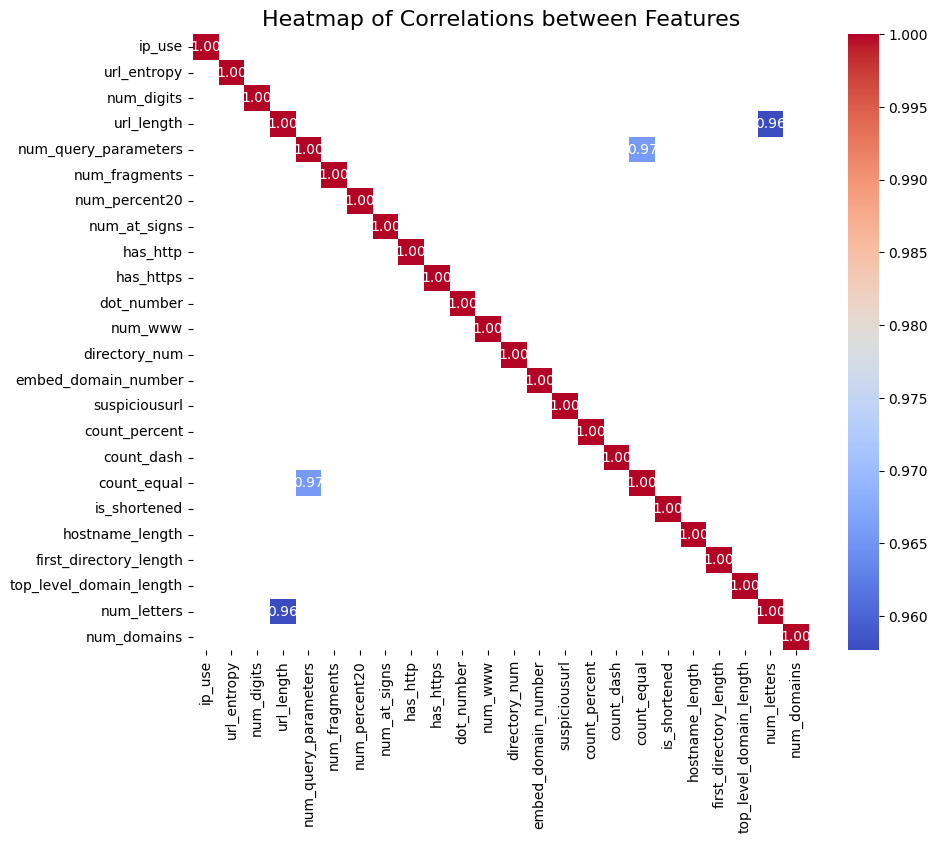

In [6]:
# showing features heatmap

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

correlation_matrix = df.drop(columns=['type', 'url']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, mask = (np.abs(correlation_matrix) <= 0.9))
plt.title("Heatmap of Correlations between Features", fontsize=16)
plt.show()

In [7]:
# we will remove, given the heatmap, the features with a correlation >= 0.9. List:
#count_equal, url_length
df = df.drop(columns=[ "count_equal", "url_length"])

print(f"Total no. of features after removal: { df.drop(columns=['type', 'url']).shape[1] }")
print(f"Features list: {df.drop(columns=['type', 'url']).columns.tolist()}" )

Total no. of features after removal: 22
Features list: ['ip_use', 'url_entropy', 'num_digits', 'num_query_parameters', 'num_fragments', 'num_percent20', 'num_at_signs', 'has_http', 'has_https', 'dot_number', 'num_www', 'directory_num', 'embed_domain_number', 'suspiciousurl', 'count_percent', 'count_dash', 'is_shortened', 'hostname_length', 'first_directory_length', 'top_level_domain_length', 'num_letters', 'num_domains']


In [8]:
# we divide the dataset into training set (80%) and test set (20%)
from sklearn.model_selection import train_test_split
from utils.utils import printInfo

train_ratio = 0.80
test_ratio = 0.20
x_train_unbalanced, x_test, y_train_unbalanced, y_test = train_test_split(df.drop(columns=["type", "url"]).copy(), df["type"].copy(), test_size=1-train_ratio, shuffle=True, stratify=df["type"].copy())

printInfo("training with outliers", y_train_unbalanced)

training with outliers samples [tot: 512895]:
 phishing class: 75274 (14.68% of total)
 benign class: 342459 (66.77% of total)
 defacement class: 76246 (14.87% of total)
 malware class: 18916 (3.69% of total)


In [9]:
# We remove outliers from the training set.
# We decided to set a fairly conservative threshold (3x IQR) given the nature of the numerous outliers, which do not arise from measurement errors, 
# but represent possible malicious URLs or edge cases. Removing them too aggressively (1.5xIQR) would risk losing relevant examples for the model. 
# The larger threshold maximizes the retention of potentially informative data while reducing excessive extreme values.
from utils.utils import remove_outliers

x_train_clean_unbalanced = remove_outliers(x_train_unbalanced)
y_train_clean_unbalanced = y_train_unbalanced[x_train_clean_unbalanced.index]

printInfo("training without outliers", y_train_clean_unbalanced)
print(f"Reduction of the training dataset by {x_train_unbalanced.shape[0] - x_train_clean_unbalanced.shape[0]} elements ({((x_train_unbalanced.shape[0] - x_train_clean_unbalanced.shape[0]) / x_train_unbalanced.shape[0]) * 100:.2f}% reduction)")

printInfo("test", y_test)

training without outliers samples [tot: 491075]:
 phishing class: 71952 (14.65% of total)
 benign class: 329538 (67.11% of total)
 defacement class: 73461 (14.96% of total)
 malware class: 16124 (3.28% of total)
Reduction of the training dataset by 21820 elements (4.25% reduction)
test samples [tot: 128224]:
 benign class: 85615 (66.77% of total)
 phishing class: 18818 (14.68% of total)
 malware class: 4729 (3.69% of total)
 defacement class: 19062 (14.87% of total)


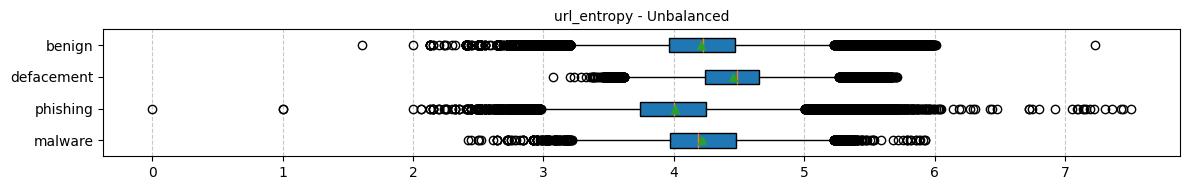

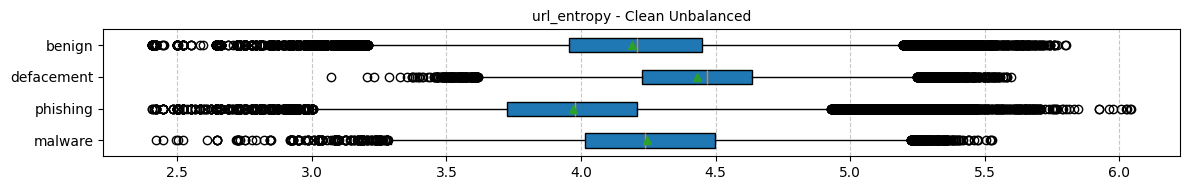

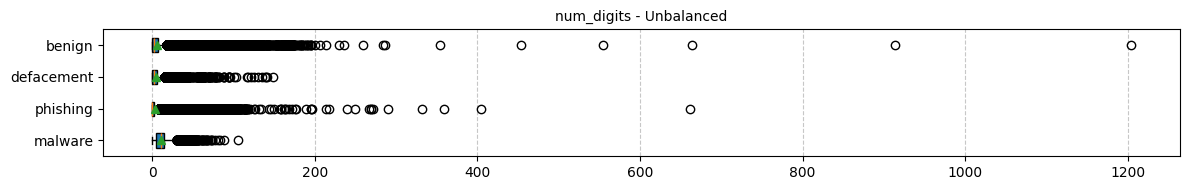

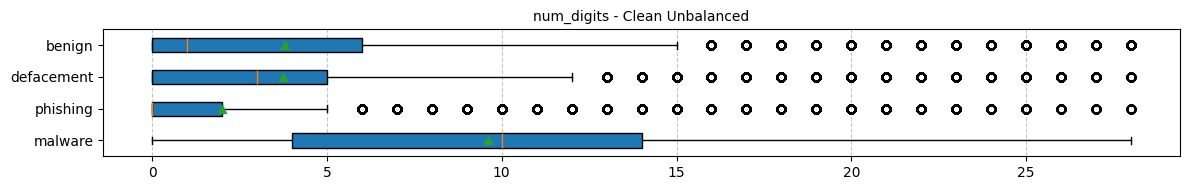

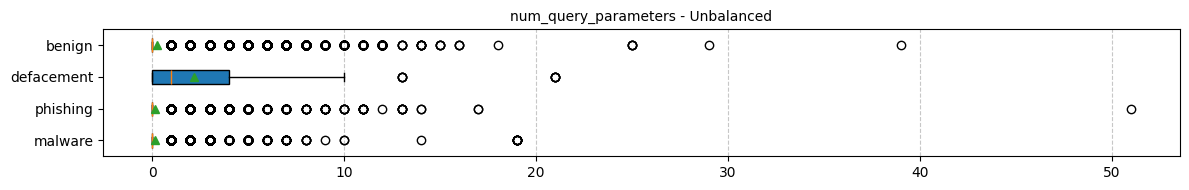

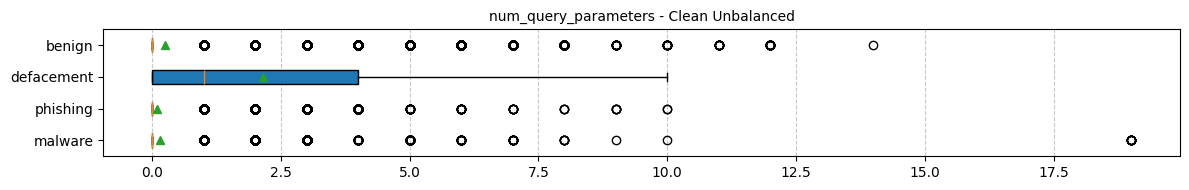

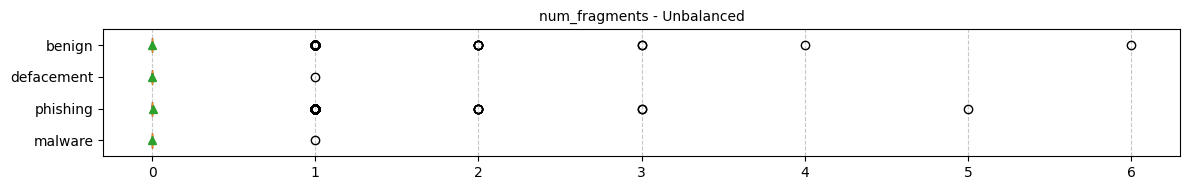

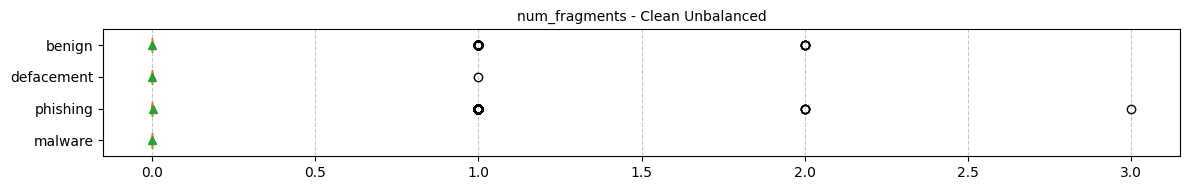

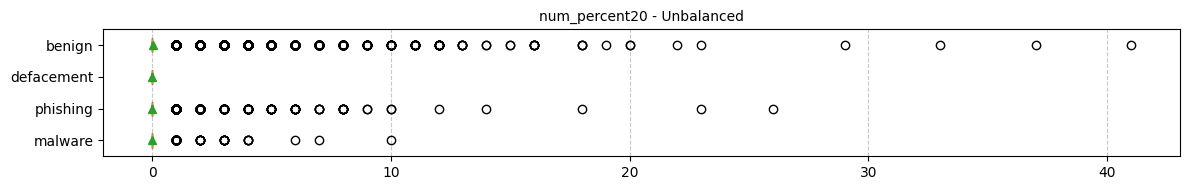

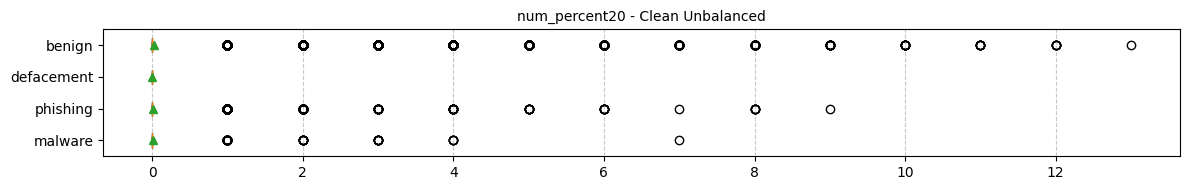

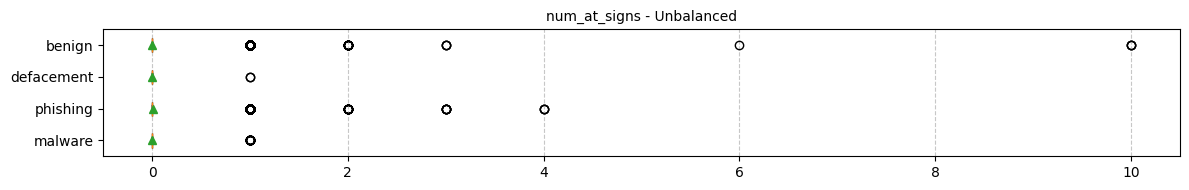

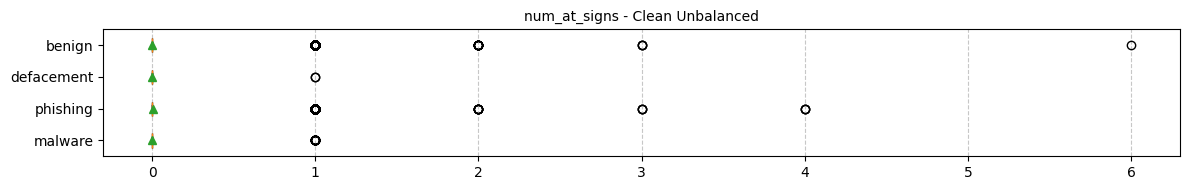

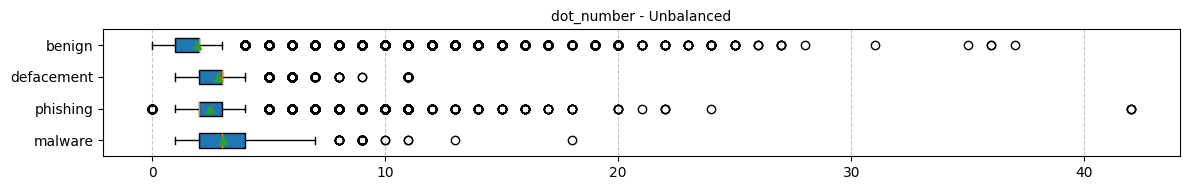

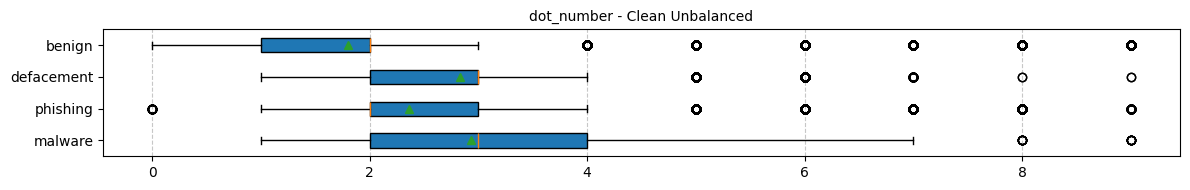

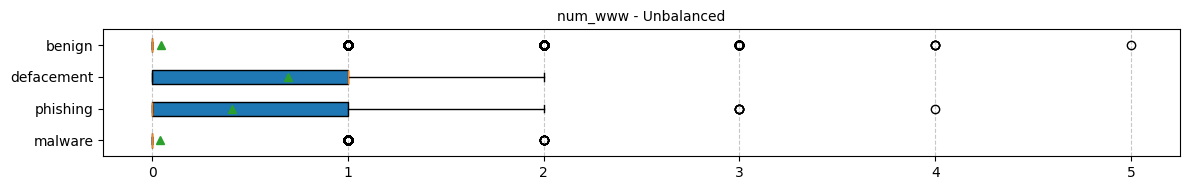

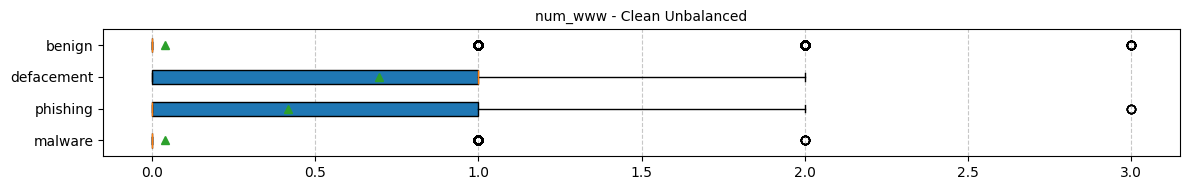

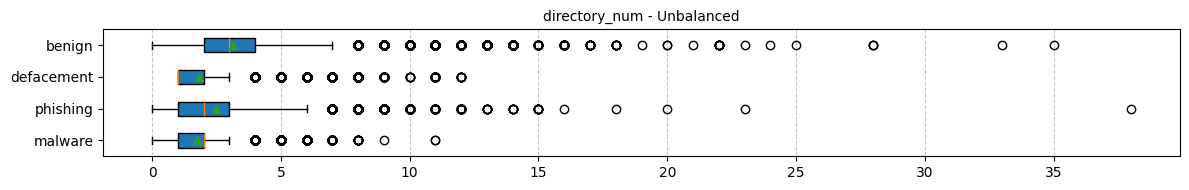

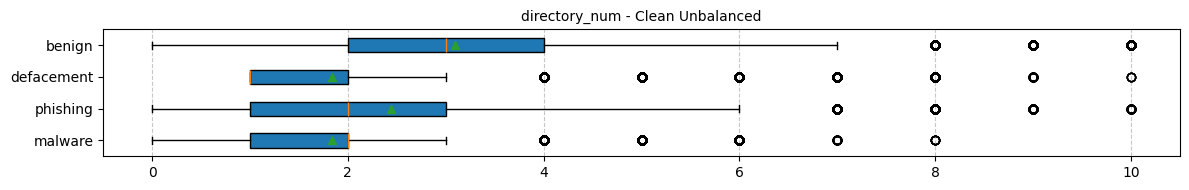

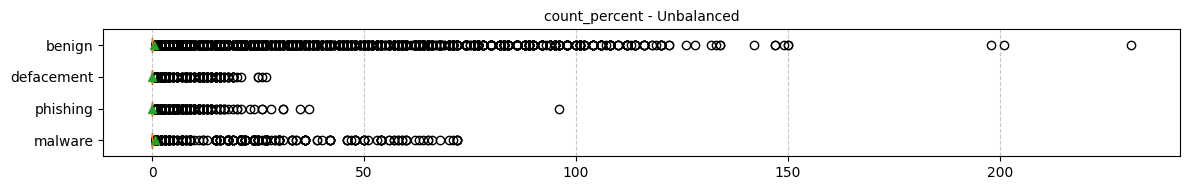

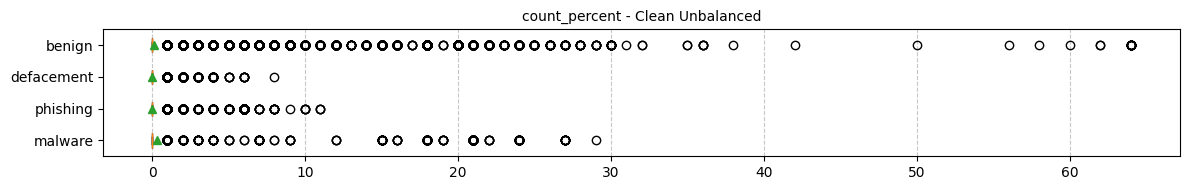

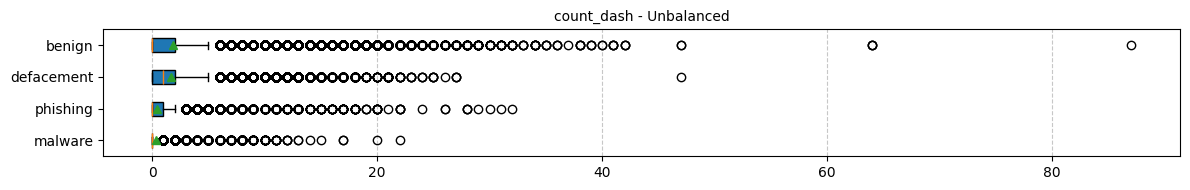

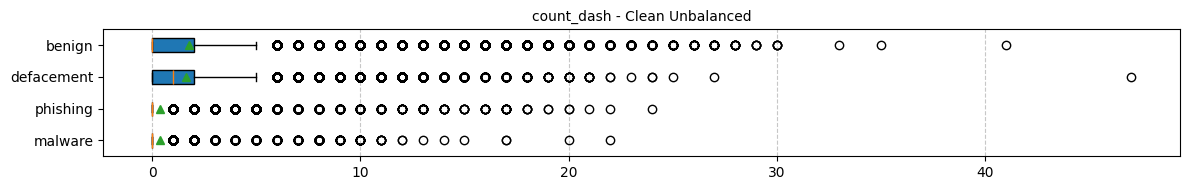

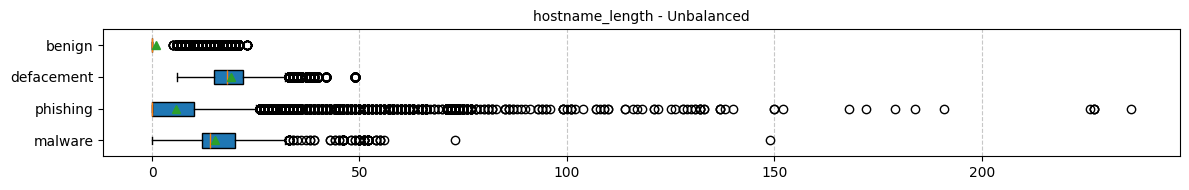

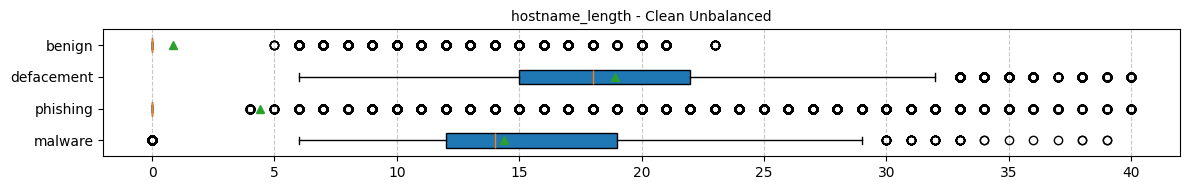

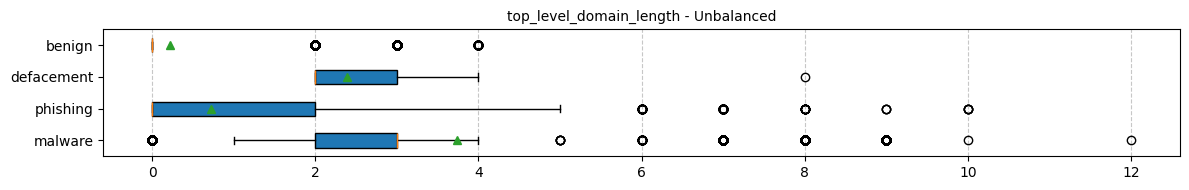

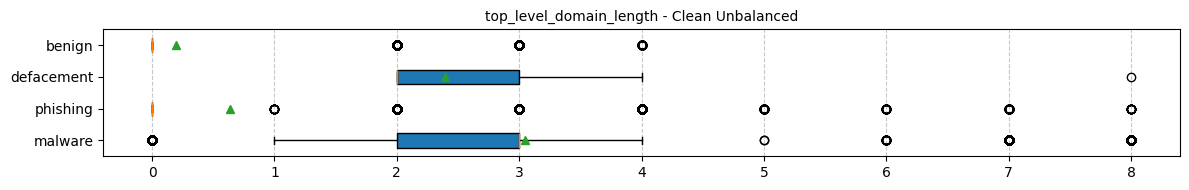

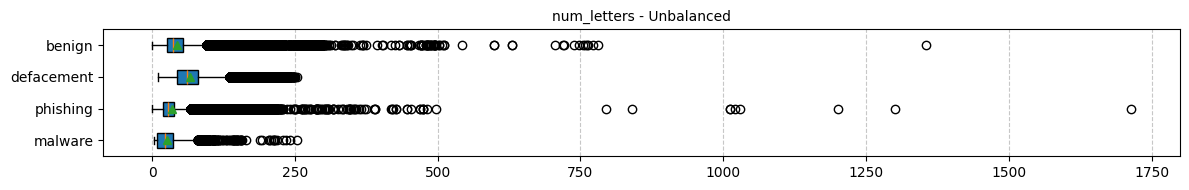

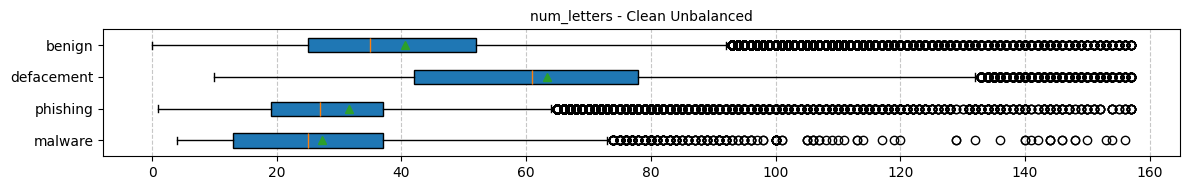

In [10]:
# We create two box plots for each of these features. The first is for the dataset with outliers, the second without them.
import matplotlib.pyplot as plt

features = ['url_entropy', 'num_digits', 'num_query_parameters', 'num_fragments', 'num_percent20', 'num_at_signs', 'dot_number', 'num_www', 'directory_num', 'count_percent', 'count_dash', 'hostname_length', 'top_level_domain_length', 'num_letters']
classes = df["type"].unique()

for feature in features:
    plt.figure(figsize=(12, 2))
    
    # First boxplot with x_train_unbalanced and y_train_unbalanced
    data = [x_train_unbalanced[y_train_unbalanced == class_label][feature].dropna() for class_label in classes]
    plt.boxplot(data, vert=False, patch_artist=True, showmeans=True, labels=classes)
    plt.title(f'{feature} - Unbalanced', fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Second boxplot with x_train_clean_unbalanced and y_train_clean_unbalanced
    plt.figure(figsize=(12, 2))
    data_clean = [x_train_clean_unbalanced[y_train_clean_unbalanced == class_label][feature].dropna() for class_label in classes]
    plt.boxplot(data_clean, vert=False, patch_artist=True, showmeans=True, labels=classes)
    plt.title(f'{feature} - Clean Unbalanced', fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [11]:
# one aspect that we notice from the above output is the imbalance, in terms of number of samples, of the malicious class compared to the benign one.
from utils.utils import balance_data_undersample_benign

x_train, y_train = balance_data_undersample_benign(x_train_unbalanced, y_train_unbalanced)
x_train_clean, y_train_clean = balance_data_undersample_benign(x_train_clean_unbalanced, y_train_clean_unbalanced) # senza outliers
printInfo("training balanced", y_train)
print()
printInfo("training cleaned balanced", y_train_clean)

training balanced samples [tot: 340872]:
 benign class: 170436 (50.00% of total)
 defacement class: 76246 (22.37% of total)
 malware class: 18916 (5.55% of total)
 phishing class: 75274 (22.08% of total)

training cleaned balanced samples [tot: 323074]:
 benign class: 161537 (50.00% of total)
 defacement class: 73461 (22.74% of total)
 malware class: 16124 (4.99% of total)
 phishing class: 71952 (22.27% of total)


## Random Forest

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.9581 ± 0.0009
Mean F1 Score: 0.9576 ± 0.0010
Mean AUC Score: 0.9882 ± 0.0003

Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.98      0.97     85615
    phishing       0.98      0.99      0.98     19062
  defacement       0.98      0.92      0.95      4729
     malware       0.89      0.83      0.86     18818

    accuracy                           0.96    128224
   macro avg       0.95      0.93      0.94    128224
weighted avg       0.96      0.96      0.96    128224


AUC Score: 0.9885


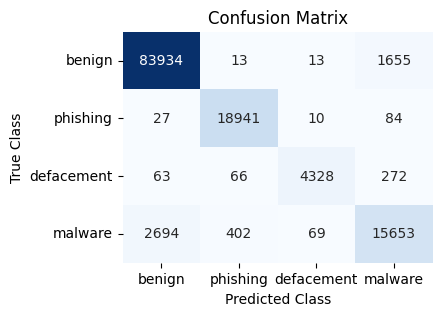

RandomForestClassifier()

In [12]:
# unbalanced, with outliers
from sklearn.ensemble import RandomForestClassifier
from utils.utils import evaluate_model_with_cv

evaluate_model_with_cv(x_train_unbalanced, y_train_unbalanced, RandomForestClassifier(), x_test, y_test)

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.9564 ± 0.0003
Mean F1 Score: 0.9558 ± 0.0003
Mean AUC Score: 0.9872 ± 0.0003

Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.98      0.97     85615
    phishing       0.97      0.99      0.98     19062
  defacement       0.98      0.90      0.94      4729
     malware       0.88      0.83      0.85     18818

    accuracy                           0.96    128224
   macro avg       0.95      0.93      0.94    128224
weighted avg       0.96      0.96      0.96    128224


AUC Score: 0.9878


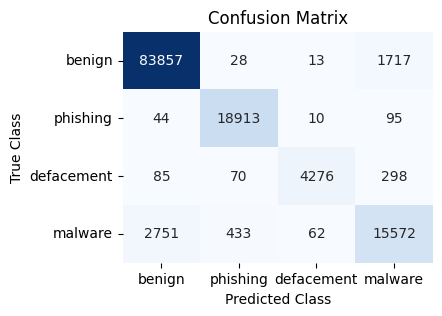

RandomForestClassifier()

In [13]:
# unbalanced, w/o outliers
from sklearn.ensemble import RandomForestClassifier
from utils.utils import evaluate_model_with_cv

evaluate_model_with_cv(x_train_clean_unbalanced, y_train_clean_unbalanced, RandomForestClassifier(), x_test, y_test)

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.9464 ± 0.0004
Mean F1 Score: 0.9460 ± 0.0005
Mean AUC Score: 0.9887 ± 0.0001

Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.97      0.97     85615
    phishing       0.97      0.99      0.98     19062
  defacement       0.98      0.92      0.95      4729
     malware       0.83      0.86      0.85     18818

    accuracy                           0.95    128224
   macro avg       0.94      0.93      0.94    128224
weighted avg       0.95      0.95      0.95    128224


AUC Score: 0.9890


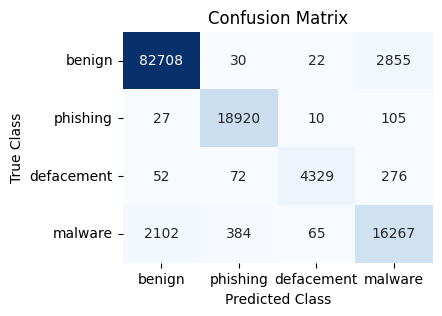

['random_forest_model.joblib']

In [14]:
# balanced, with outliers
from sklearn.ensemble import RandomForestClassifier
from utils.utils import evaluate_model_with_cv
from joblib import dump

rf_classifier=evaluate_model_with_cv(x_train, y_train, RandomForestClassifier(), x_test, y_test)
# Save the trained model
dump(rf_classifier, 'random_forest_model.joblib')

Let's give some interpretability

<Figure size 1000x800 with 0 Axes>

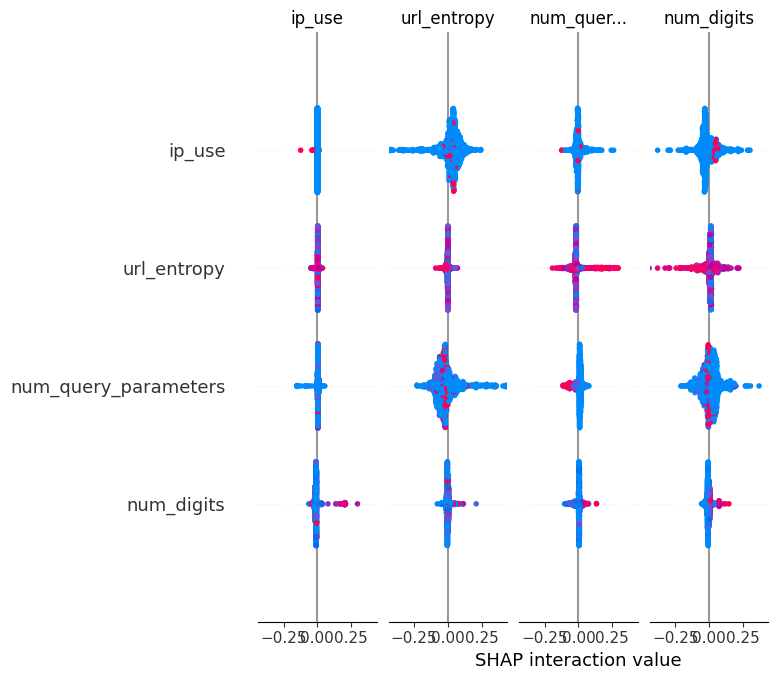

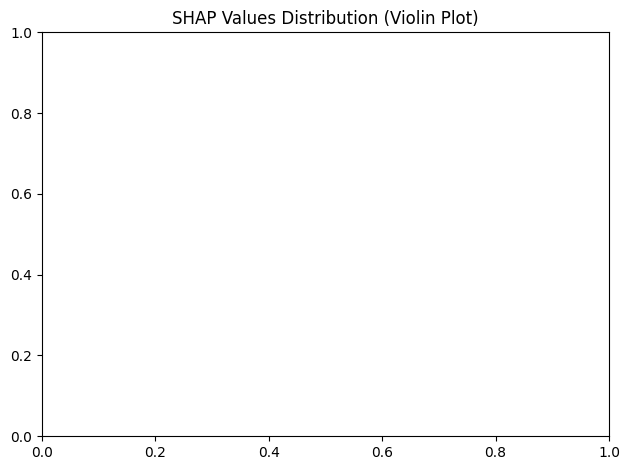

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1000x800 with 0 Axes>

In [15]:
import shap


# Create explainer
explainer = shap.TreeExplainer(rf_classifier)

# Calculate SHAP values on a sample of training data (for performance)
sample_size = 1000
sample_index = np.random.choice(x_train.shape[0], sample_size, replace=False)
x_train_sample = x_train.iloc[sample_index]

shap_values = explainer.shap_values(x_train_sample)

# Plot violin plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, x_train_sample, plot_type="violin")
plt.title("SHAP Values Distribution (Violin Plot)")
plt.tight_layout()
plt.show()

# Plot specific summary plot for Random Forest (shows feature importance and impact)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values[1], x_train_sample, plot_type="bar")  # [1] selects the class we want to analyze
plt.title("SHAP Feature Importance for Random Forest")
plt.tight_layout()
plt.show()

# Plot a detailed SHAP dependence plot for the most important feature
# Get the feature with highest mean absolute SHAP value
shap_importance = np.abs(shap_values[1]).mean(0)
most_important_feature = x_train.columns[shap_importance.argmax()]

plt.figure(figsize=(10, 6))
shap.dependence_plot(most_important_feature, shap_values[1], x_train_sample)
plt.title(f"SHAP Dependence Plot for {most_important_feature}")
plt.tight_layout()
plt.show()

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.9315 ± 0.0004
Mean F1 Score: 0.9308 ± 0.0004
Mean AUC Score: 0.9823 ± 0.0004

Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.96      0.96     85615
    phishing       0.96      0.99      0.97     19062
  defacement       0.97      0.89      0.93      4729
     malware       0.79      0.83      0.81     18818

    accuracy                           0.94    128224
   macro avg       0.92      0.92      0.92    128224
weighted avg       0.94      0.94      0.94    128224


AUC Score: 0.9829


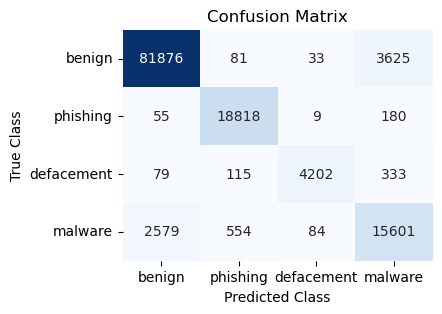

In [36]:
# balanced, w/o outliers
from sklearn.ensemble import RandomForestClassifier
from utils.utils import evaluate_model_with_cv


rf_classifier = evaluate_model_with_cv(x_train_clean, y_train_clean, RandomForestClassifier(), x_test, y_test)


## Logistic Regression

In [37]:
# we perform a data normalization, necessary for logistic regression
from sklearn.preprocessing import StandardScaler

COLUMNS_TO_IGNORE = ['ip_use', 'has_http', 'has_https', 'suspiciousurl'] # binary features

# defining features to normalize (all except those to ignore)
non_binary_columns = [col for col in x_train.columns if col not in COLUMNS_TO_IGNORE]

# scaling with StandardScaler
scaler = StandardScaler()

# training set with outliers
x_train_unbalanced_scaled = x_train_unbalanced.copy()
x_train_unbalanced_scaled[non_binary_columns] = scaler.fit_transform(x_train_unbalanced[non_binary_columns])

# training set w/o outliers
x_train_clean_unbalanced_scaled = x_train_clean_unbalanced.copy()
x_train_clean_unbalanced_scaled[non_binary_columns] = scaler.fit_transform(x_train_clean_unbalanced_scaled[non_binary_columns])

# test set (NOT MODIFIED)
x_test_scaled = x_test.copy()
x_test_scaled[non_binary_columns] = scaler.transform(x_test[non_binary_columns])

In [38]:
# binary regression cannot accept values ​​other than 0 and 1, so we change the classes to only two.
from utils.utils import balance_data_undersample_benign, merge_classes_to_binary

x_binary_train_scaled, y_binary_train = balance_data_undersample_benign(x_train_unbalanced_scaled, merge_classes_to_binary(y_train_unbalanced))
x_binary_train_clean_scaled, y_binary_train_clean = balance_data_undersample_benign(x_train_clean_unbalanced_scaled, merge_classes_to_binary(y_train_clean_unbalanced))

y_binary_test = merge_classes_to_binary(y_test)

printInfo("training binary balanced", y_binary_train)
print()
printInfo("training binary cleaned balanced", y_binary_train_clean)

training binary balanced samples [tot: 340872]:
 benign class: 170436 (50.00% of total)
 malignant class: 170436 (50.00% of total)

training binary cleaned balanced samples [tot: 320870]:
 benign class: 160435 (50.00% of total)
 malignant class: 160435 (50.00% of total)


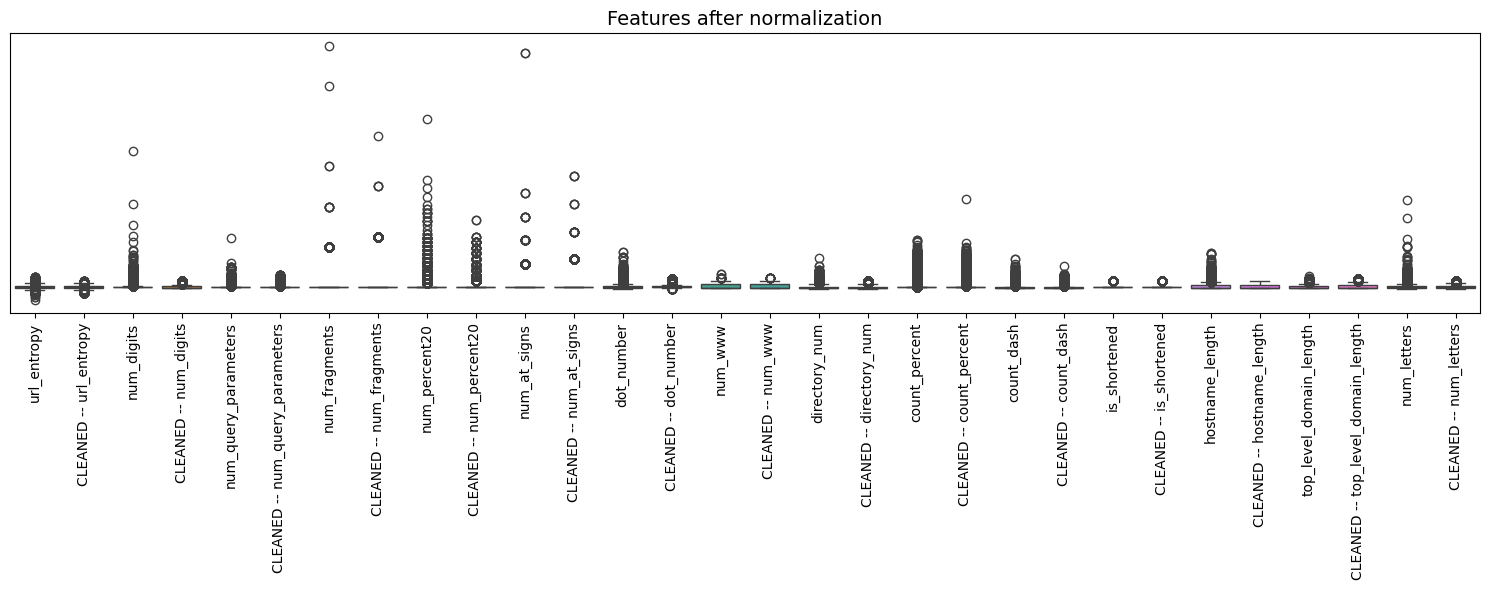

In [39]:
# showing the distribution of features with and without outliers (it takes about 30 seconds)
import matplotlib.pyplot as plt
import seaborn as sns

combined_data = pd.DataFrame()
for column in non_binary_columns:
    combined_data[column] = x_binary_train_scaled[column]
    combined_data["CLEANED -- " + column] = x_binary_train_clean_scaled[column]

columns_for_plot = []
for column in non_binary_columns:
    columns_for_plot.append(column)
    columns_for_plot.append("CLEANED -- " + column)

# Creazione del boxplot
plt.figure(figsize=(len(columns_for_plot) * 0.5, 6))
sns.boxplot(data=combined_data[columns_for_plot])
plt.title('Features after normalization', fontsize=14)
plt.xticks(rotation=90)
plt.gca().axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.9014 ± 0.0007
Mean F1 Score: 0.8994 ± 0.0008
Mean AUC Score: 0.9454 ± 0.0003

Classification Report:
              precision    recall  f1-score   support

      benign       0.90      0.96      0.93     85615
   malignant       0.91      0.78      0.84     42609

    accuracy                           0.90    128224
   macro avg       0.90      0.87      0.88    128224
weighted avg       0.90      0.90      0.90    128224


AUC Score: 0.9426


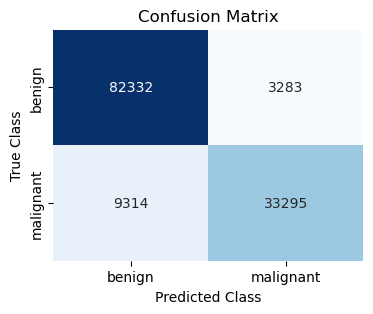

In [40]:
# unbalanced and normalized, with outliers
from sklearn.linear_model import LogisticRegression
from utils.utils import evaluate_model_with_cv

evaluate_model_with_cv(x_train_unbalanced_scaled, merge_classes_to_binary(y_train_unbalanced), LogisticRegression(), x_test_scaled, y_binary_test, ['benign', 'malignant'])

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.9036 ± 0.0008
Mean F1 Score: 0.9014 ± 0.0008
Mean AUC Score: 0.9482 ± 0.0009

Classification Report:
              precision    recall  f1-score   support

      benign       0.90      0.96      0.93     85615
   malignant       0.91      0.77      0.84     42609

    accuracy                           0.90    128224
   macro avg       0.90      0.87      0.88    128224
weighted avg       0.90      0.90      0.90    128224


AUC Score: 0.9412


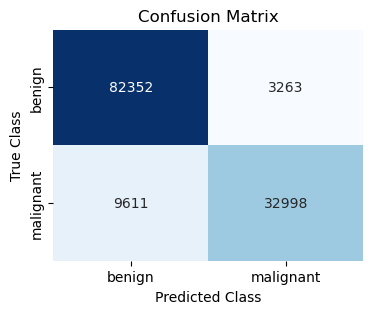

In [41]:
# unbalanced and normalized, without outliers
from sklearn.linear_model import LogisticRegression
from utils.utils import evaluate_model_with_cv

evaluate_model_with_cv(x_train_clean_unbalanced_scaled, merge_classes_to_binary(y_train_clean_unbalanced), LogisticRegression(), x_test_scaled, y_binary_test, ['benign', 'malignant'])

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.8751 ± 0.0010
Mean F1 Score: 0.8749 ± 0.0010
Mean AUC Score: 0.9461 ± 0.0008

Classification Report:
              precision    recall  f1-score   support

      benign       0.92      0.92      0.92     85615
   malignant       0.83      0.83      0.83     42609

    accuracy                           0.89    128224
   macro avg       0.87      0.88      0.87    128224
weighted avg       0.89      0.89      0.89    128224


AUC Score: 0.9439


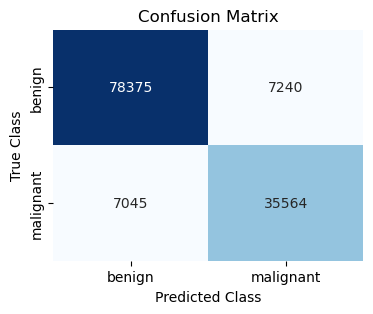

In [42]:
# balanced and normalized, with outliers
from sklearn.linear_model import LogisticRegression
from utils.utils import evaluate_model_with_cv

evaluate_model_with_cv(x_binary_train_scaled, y_binary_train, LogisticRegression(), x_test_scaled, y_binary_test, ['benign', 'malignant'])

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.8769 ± 0.0010
Mean F1 Score: 0.8766 ± 0.0010
Mean AUC Score: 0.9494 ± 0.0005

Classification Report:
              precision    recall  f1-score   support

      benign       0.92      0.92      0.92     85615
   malignant       0.83      0.83      0.83     42609

    accuracy                           0.89    128224
   macro avg       0.87      0.87      0.87    128224
weighted avg       0.89      0.89      0.89    128224


AUC Score: 0.9430


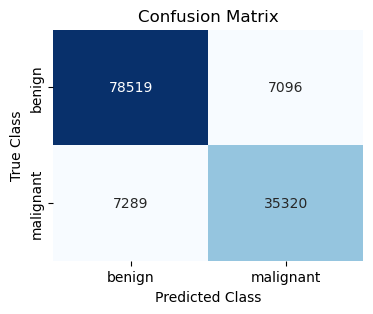

In [43]:
# balanced and normalized, without outliers
from sklearn.linear_model import LogisticRegression

evaluate_model_with_cv(x_binary_train_clean_scaled, y_binary_train_clean, LogisticRegression(), x_test_scaled, y_binary_test, ['benign', 'malignant'])

## PCA

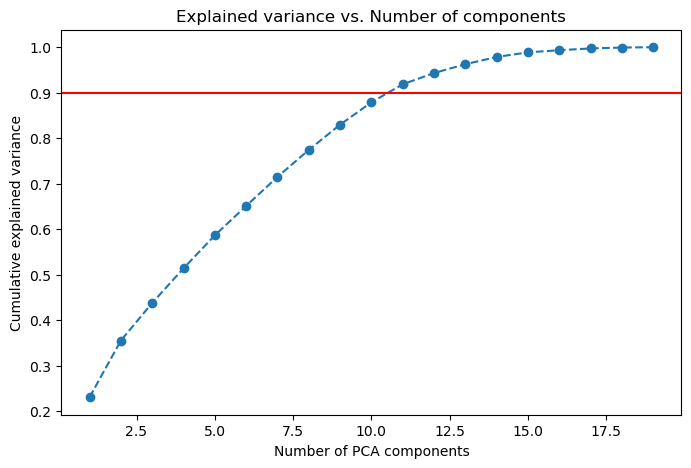

Cross-Validation F1-Weighted: 0.8468
Classification Report (Test Set):
              precision    recall  f1-score   support

      benign       0.89      0.91      0.90     85615
   malignant       0.82      0.78      0.80     42609

    accuracy                           0.87    128224
   macro avg       0.86      0.85      0.85    128224
weighted avg       0.87      0.87      0.87    128224


AUC Score: 0.9217


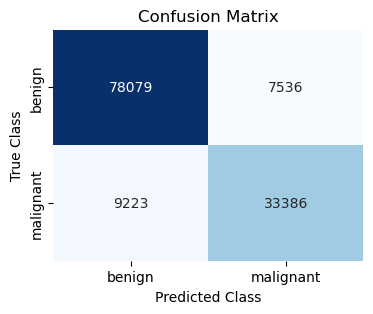

In [47]:
# per logistic regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

COLUMNS_TO_IGNORE = ['ip_use', 'has_http', 'has_https', 'suspiciousurl']

# 1. prepare data
target_column = 'type'
columns_to_scale = [col for col in df.columns if col not in COLUMNS_TO_IGNORE + ['url', target_column]]

class_mapping = {
    'benign': 'benign',
    'defacement': 'malignant',
    'phishing': 'malignant',
    'malware': 'malignant'
}
df_binary = df.copy()
df_binary[target_column] = df[target_column].map(class_mapping)

X = df_binary.drop(columns=['url', target_column])
y = df_binary[target_column]

# 2. split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. apply random undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

# 4. create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', COLUMNS_TO_IGNORE)
    ]
)

# 4.5. explained variance analysis
pca_temp = PCA()
pca_temp.fit(preprocessor.fit_transform(X_train))
explained_variance = np.cumsum(pca_temp.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='-')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance vs. Number of components')
plt.show()

# 5. create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# 6. cross-validation
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_weighted')
print(f"Cross-Validation F1-Weighted: {scores.mean():.4f}")

# 7. final fit
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# 8. evaluation
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

y_prob = pipeline.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test.map({'benign': 0, 'malignant': 1}), y_prob)
print(f"\nAUC Score: {auc_score:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


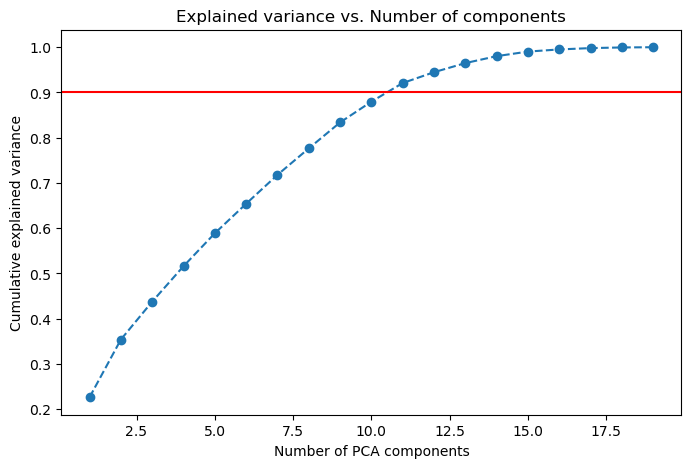

Cross-Validation F1-Weighted: 0.8962
Classification Report (Test Set):
              precision    recall  f1-score   support

      benign       0.97      0.89      0.93     85615
  defacement       0.93      0.97      0.95     19062
     malware       0.81      0.92      0.86      4729
    phishing       0.64      0.82      0.72     18818

    accuracy                           0.90    128224
   macro avg       0.84      0.90      0.87    128224
weighted avg       0.91      0.90      0.90    128224



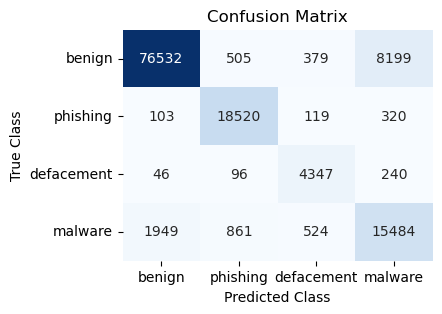

In [46]:
# random forest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

COLUMNS_TO_IGNORE = ['ip_use', 'has_http', 'has_https', 'suspiciousurl']

# 1. prepare data
target_column = 'type'
columns_to_scale = [col for col in df.columns if col not in COLUMNS_TO_IGNORE + ['url', target_column]]

X = df.drop(columns=['url', target_column])
y = df[target_column]

# 2. split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# 3. apply random undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

# 4. create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', COLUMNS_TO_IGNORE)
    ]
)

# 4.5. explained variance analysis
pca_temp = PCA()
pca_temp.fit(preprocessor.fit_transform(X_train))
explained_variance = np.cumsum(pca_temp.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='-')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance vs. Number of components')
plt.show()

# 5. create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=10)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 6. cross-validation
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_weighted')
print(f"Cross-Validation F1-Weighted: {scores.mean():.4f}")

# 7. final fit
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# 8. evaluation
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['benign', 'phishing', 'defacement', 'malware'], yticklabels=['benign', 'phishing', 'defacement', 'malware'])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()
